In [20]:
import pandas as pd
import numpy as np

In [24]:
import scipy
from scipy import stats
from statsmodels.stats import multitest
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Gene Annotation

In [1]:
gtf_file="gencode.v47.annotation.gtf"
#read gencode.v47.annotation.gtf file
with open(gtf_file) as f:
    gtf = list(f)
    
gtf = [x for x in gtf if not x.startswith('#')]

In [2]:
gtf = [x for x in gtf if 'gene_name "' in x and 'transcript_id "' in x]

In [3]:
gtf_gene_ensg = list(map(lambda x: (x.split('gene_id "')[1].split('"')[0].split(".")[0],
                                    x.split('gene_name "')[1].split('"')[0]), gtf))

In [5]:
gtf_gene_ensg_last = list(set(gtf_gene_ensg))
gtf_gene_ensg_last = dict(gtf_gene_ensg_last)
gtf_gene_ensg_last = {k.split('.')[0]: v for k, v in gtf_gene_ensg_last.items() if k != ""}

In [27]:
# gtf_gene_ensg_last

In [6]:
gtf_last = list(set(list(set(gtf_gene_ensg))))
gtf_last = dict(gtf_last)
gtf_dict = {k: v for k, v in gtf_last.items() if k != ""}

# TMM Normalized Data

In [11]:
data = pd.read_csv('gene_level_count_tmm_normalized.csv', index_col=0)

In [12]:
data['Gene Name'] = data.index.map(gtf_dict)

In [13]:
data = data[~data['Gene Name'].str.startswith('ENSG')]
data.columns = pd.DataFrame(data.columns)[0].str.split('_GT25',expand=True)[0].values

In [27]:
data_ = data.loc[:,['Medium','IFNa','IFNg','IFNg___IFNa','IFNa___anti-IFNa','IFNg___anti-IFNg',
            '1021_V1','1021_V2','1021_V2__a-IFNa','1021_V2__a-IFNg___a-IFNa','1021_V5','1021_V5__a-IFNg',
            '1021_V5__a-IFNg___a-IFNa','Undetermined_S0', 'Gene Name']]
data_ = data_.set_index('Gene Name')
data_.columns = data_.columns.str.replace("__","")
data_.rename(columns={'IFNg___IFNa':'IFNa_IFNg',"IFNa___anti-IFNa":"IFNa-aIFNa",}, inplace=True)

# Z-score type i and ii gene expression

In [45]:
# Gene List (Example: Type-I short gene list)
type1_list=['BATF2', 'CMPK2', 'CXCL10',	'CXCL11', 'DDX60', 'DHX58',	'EIF2AK2', 'HELZ2', 'IFI27']

In [46]:
sample_col = data_.iloc[:,0:4].columns

In [47]:
zscore = scipy.stats.zscore(data_.loc[[i for i in data_.index if i in type1_list],sample_col], axis=1)

In [48]:
df_melted = pd.melt(zscore.reset_index(), id_vars=["Gene Name"])

In [49]:
df_melted = df_melted.dropna()

/tmp/ipykernel_1321909/1681957965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  swarm = sns.swarmplot(
/tmp/ipykernel_1321909/1681957965.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  swarm = sns.swarmplot(
/tmp/ipykernel_1321909/1681957965.py:20: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


Text(0.5, 1.0, 'ISG High Gene')

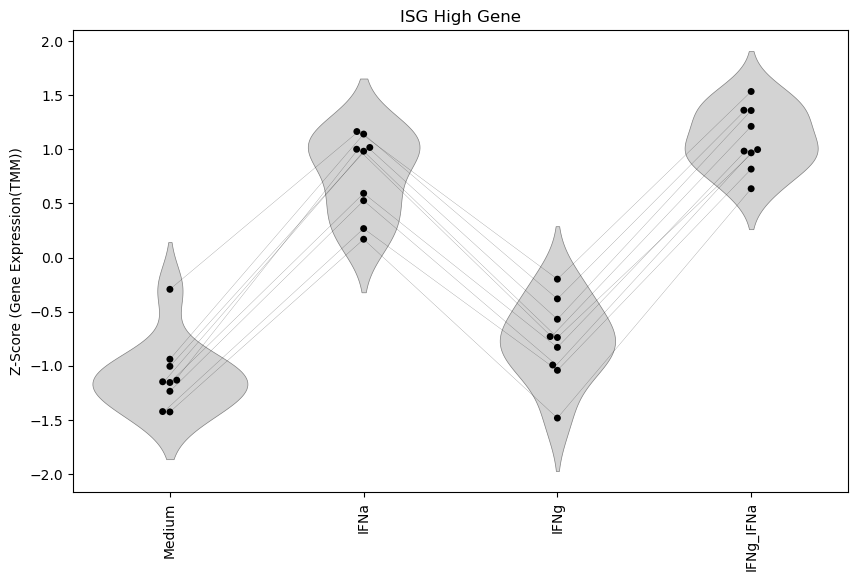

In [50]:
fig1 = plt.figure(figsize=(10, 6))
swarm = sns.swarmplot(
           x='variable', 
           y='value', 
           data=df_melted, 
           legend=False, 
           palette=['k'], 
         )

combine_off = []
collections = swarm.collections
for col in collections:
    offsets = col.get_offsets()
    plot_data = pd.DataFrame(offsets, columns=['x', 'y'])
    plot_data = plot_data.sort_values('y')
    combine_off.append(plot_data)
combine_off = pd.concat(combine_off).reset_index(drop=True)
combine_off['sub'] = df_melted['Gene Name'].values

sns.lineplot(
            x='x', 
            y='y', 
            data=combine_off, 
            hue='sub', 
            legend=False, 
            palette=['k'],
            markers=False, 
            linewidth=0.1,
            )

sns.violinplot(
            data=df_melted, 
            x="variable", 
            y="value", 
            inner=None, 
            color="lightgray", 
            linewidth=0.5,
            )

plt.xticks(rotation=90)
plt.ylabel('Z-Score (Gene Expression(TMM))')
plt.xlabel('')
plt.title('ISG High Gene')

In [53]:
sample_col = ['Medium', 'IFNa', 'IFNg', 'IFNg_IFNa']

In [54]:
data_plot = data_.loc[[i for i in data_.index if i in ['MX1']],sample_col].reset_index(
    ).melt(id_vars='Gene Name',var_name='variable', value_name='value')

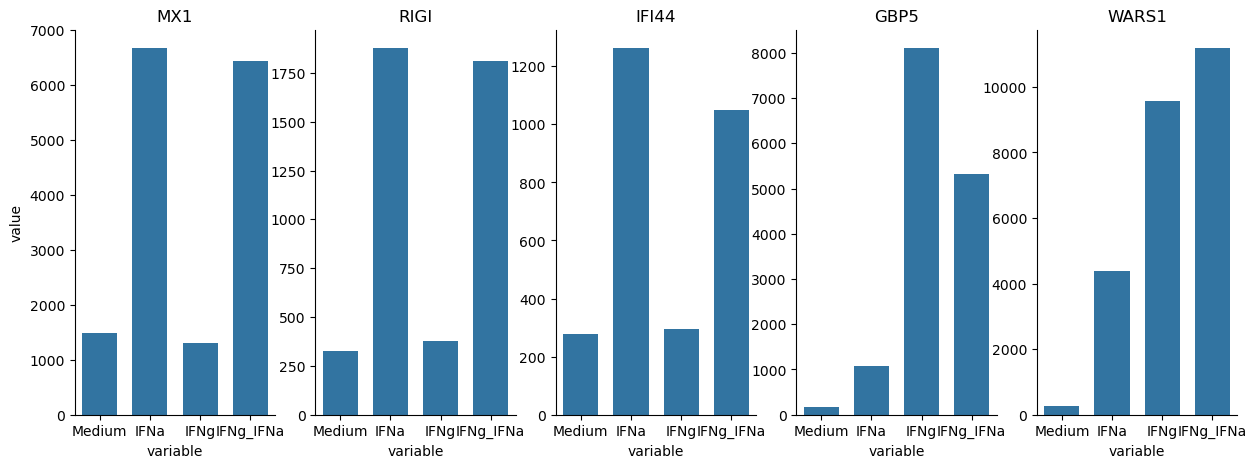

In [56]:

gene_lst=['MX1','RIGI','IFI44','GBP5','WARS1']

fig, ax = plt.subplots(1,5,figsize=[15,5], # 6,3.5
                       #sharey=True
                      )
axes = ax.ravel()
ax_count=0
for gene_select in gene_lst:
    data_plot = data_.loc[[i for i in data_.index if i in [gene_select]],sample_col].reset_index(
        ).melt(id_vars='Gene Name',var_name='variable', value_name='value')
    
    # data_plot['value'] = np.log2(data_plot['value']).values
    # 
    sns.barplot(data = data_plot, 
                 x='variable',
                 y='value',
                 # palette='tab10',
                 # hue='variable',
                 ax=axes[ax_count],
                width=0.7
                    )

    axes[ax_count].set_title(gene_select)
    ax_count += 1


    for ax in axes[1:]:
        # ax.yaxis.set_ticks([])          # Hide y-axis ticks
        # ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('') 
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)

# plt.savefig('Figures/Example_expression_anti.eps')

# Interferon genes

In [58]:
sample_col = ['Medium','IFNa', 'IFNg']

In [59]:
div_check_2 = data_.loc[:,sample_col]

In [60]:
div_check_2 = div_check_2[~((div_check_2 < 10).any(axis=1))]

In [61]:
div_check_2['FC_IFNa'] = np.log2(div_check_2.iloc[:, 1] / div_check_2.iloc[:, 0])
div_check_2['FC_IFNg'] = np.log2(div_check_2.iloc[:, 2] / div_check_2.iloc[:, 0])
div_check_2['FC_IFNa/g'] = np.log2(div_check_2.iloc[:, 1] / div_check_2.iloc[:, 2])

In [62]:
div_check_2_up = div_check_2[~((div_check_2['FC_IFNa'] < -0.5) | (div_check_2['FC_IFNg'] < -0.5))]

In [63]:
import scanpy as sc

In [ ]:
# Load the rna-seq data or subset of interest
rna_data = sc.read_h5ad("scrna-seq.h5ad")

In [72]:
rna_data = sc.read_h5ad('myeloid.h5ad')

In [73]:
rna_data.obs = rna_data.obs.copy()
rna_data.obs['Visit'] = rna_data.obs['Visit'].str.replace(' ','_')
rna_data.obs['Visit'] = rna_data.obs['Visit'].str.replace('Baseline_2', 'Vac2_Baseline')
rna_data.obs['Vaccine'] = rna_data.obs['Vaccine'].astype(str)
rna_data.obs['person_visit'] = rna_data.obs['person'].astype(str) + '-' + rna_data.obs['Visit'].astype(str)
rna_data.obs['vaccine_person'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['person'].astype(str)
rna_data = rna_data[~( (rna_data.obs['Vaccine'] != "J&J") & (rna_data.obs['Visit'].isin(["Vac1_D7"])) )]
rna_data = rna_data[~( (rna_data.obs['Vaccine'] == "J&J") & (rna_data.obs['Visit'].isin(["Vac2_D7"])) )]
rna_data = rna_data[~(rna_data.obs['Visit'].isin(["Day70","Day180"])),:]
rna_data.obs['vaccine_visit'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)
rna_data.obs['vaccine_person_visit'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['person'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)

/tmp/ipykernel_1321909/2833221543.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_data.obs['vaccine_visit'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)


In [102]:
rna_data = rna_data[rna_data.obs['celltypes'] == 'Monocyte CD14',:]
rna_data = rna_data[rna_data.obs['new_subset_annotations_2'] != 'Monocyte CD14 ISG Inflamm.',:]
rna_data = rna_data[rna_data.obs['Vaccine'] != 'J&J',:]

In [75]:
rna_data.obs = rna_data.obs.copy()
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].replace(
    'Monocyte CD14 ISG High','ISG_High')
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].replace(
    'Monocyte CD14 ISG Dim','ISG_Dim')
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].replace(
    'Monocyte CD14','ISG_None')
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].str.replace(' ','_')

In [76]:
rna_data.obs['isg_sub_donor'] = rna_data.obs['new_subset_annotations_2'].astype(str) + '_' + rna_data.obs['person'].astype(str)
rna_data.obs['isg_sub_vac'] = rna_data.obs['new_subset_annotations_2'].astype(str) + '_' +rna_data.obs['Vaccine'].astype(str)
rna_data.obs['isg_sub_vac_donor'] = rna_data.obs['new_subset_annotations_2'].astype(str) + '_' + \
    rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['person'].astype(str)
rna_data.obs['vaccine_visit'] =  rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)
rna_data.obs['isg_vac_donor_visit'] = rna_data.obs['isg_sub_vac_donor'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)

In [84]:
# Load the data CD14-RNA-seq for visualization, which is used for ISGdim
# cd14_data = sc.read_h5ad("rna-seq-data.h5ad")

cd14_data.obs['subsets'] = pd.Categorical(cd14_data.obs['new_subset_annotations_2'].map({
    'Monocyte CD14': 'CD14 ISG Low',
    'Monocyte CD14 ISG 1': 'CD14 ISG High',
    'Monocyte CD14 ISG 2': 'CD14 ISG High',
    'Monocyte CD14 ISG (Low)': 'CD14 ISG Dim',
    'Monocyte CD14 ISG Inflamm.': 'CD14 ISG High',
}),  categories=['CD14 ISG Low', 'CD14 ISG Dim', 'CD14 ISG High'])

# our_cd14.obs['subset_vax'] = utils.make_combined_column(our_cd14, ['subsets', 'Vaccine'])
cd14_data.obs['subset_vax'] = (cd14_data.obs['subsets'].astype(str) + " " + cd14_data.obs['Vaccine'].astype(str)).values
cd14_data.obs['subset_vax'] = pd.Categorical(cd14_data.obs['subset_vax'], 
    categories=['CD14 ISG High J&J', 'CD14 ISG High Moderna', 'CD14 ISG High Pfizer',
                                          'CD14 ISG Dim J&J', 'CD14 ISG Dim Moderna', 'CD14 ISG Dim Pfizer',
                                          'CD14 ISG Low J&J', 'CD14 ISG Low Moderna', 'CD14 ISG Low Pfizer'])

In [85]:
cd14_data = cd14_data[~(cd14_data.obs['Vaccine'] == "J&J"),:]

In [87]:
div_check_2_up = div_check_2[~((div_check_2['FC_IFNa'] < -2) | (div_check_2['FC_IFNg'] < -2))]

In [88]:
type_1 = list(np.sort(div_check_2_up[(div_check_2_up['FC_IFNa/g'] > 2.2) & (div_check_2_up['FC_IFNa'] > 1.6)].index))
type_2 = list(np.sort(div_check_2_up[(div_check_2_up['FC_IFNa/g'] < -0.75) & (div_check_2_up['FC_IFNg'] > 2.5)].index))

In [91]:
print(len([i for i in type_1 if i in rna_data.raw.var_names]))
[i for i in type_1 if i not in rna_data.raw.var_names]

58


['LDAF1', 'RIGI']

In [92]:
type_1.append('DDX58') # For type_1 misssing gene

In [97]:
gene_select = [i for i in type_1 if i in rna_data.raw.var_names]

In [103]:
genedf = sc.get.obs_df(rna_data, keys=["isg_sub_vac_donor", *gene_select], use_raw=True)
dfm_rna = genedf.groupby("isg_sub_vac_donor", observed=True).mean().mean(axis=1).reset_index()

In [104]:
dfm_rna['vac'] = dfm_rna['isg_sub_vac_donor'].str.rsplit('_',n=2,expand=True)[1].values
dfm_rna['col'] = dfm_rna['isg_sub_vac_donor'].str.rsplit('_',n=2,expand=True)[0].values
dfm_rna = dfm_rna.rename(columns={0:'vals'})

In [105]:
desired_order = ['ISG_None', 'ISG_Dim', 'ISG_High']
dfm_rna["col"] = pd.Categorical(dfm_rna["col"], categories=desired_order, ordered=True)

In [1113]:
# group = ['ISG_None', 'ISG_Dim', 'ISG_High']
# df_melted = pd.melt(dfm_rna.reset_index(), id_vars=["index"])
# df_melted['isg_sub_donor'].str.rsplit('_',n=1,expand=True)[0].values

In [1114]:
# df_melted['type'] = df_melted['isg_sub_donor'].str.rsplit('_',n=1,expand=True)[0].values

In [1115]:
# dfm_rna

Text(0.5, 1.0, 'IFN-g Genes')

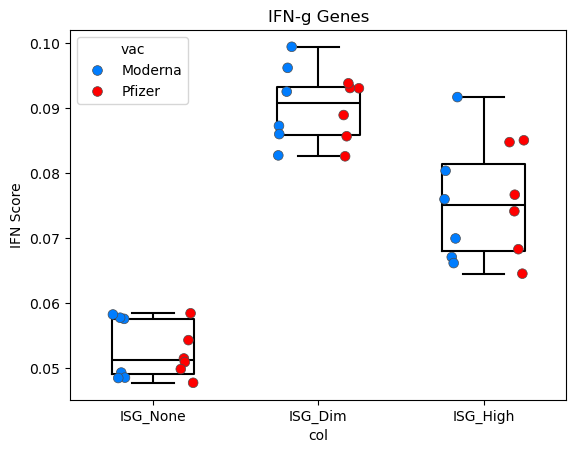

In [106]:
sns.boxplot(data=dfm_rna, x='col', y='vals',fill=False, color='k', 
                saturation=1,
                showfliers=False, dodge=False, width=0.5)

strip = sns.stripplot(x='col', y='vals', data=dfm_rna, jitter=True, 
          palette=['#007dff','#ff0000'],
          dodge=True, linewidth=0.5, size=7, legend=True, hue='vac' #marker=mark, ,
         )

plt.ylabel('IFN Score')
plt.title("IFN-g Genes")

# plt.savefig('Figures/IFNg-genes.eps')

In [127]:
X = cd14_data.raw.to_adata()[:, [i for i in gene_select if i in cd14_data.raw.var_names]].X

In [129]:
cd14_data.obs['isg_score_avg'] = X.mean(axis=1).A1 if hasattr(X, "A1") else X.mean(axis=1)

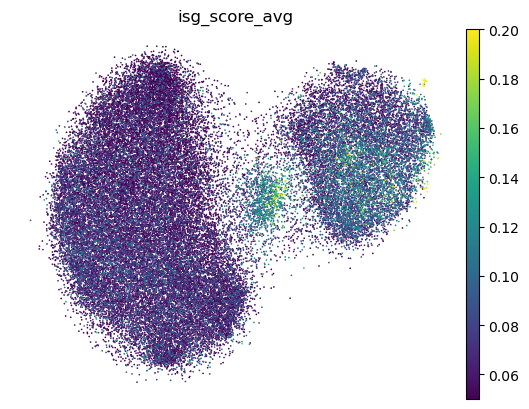

In [138]:
fig = sc.pl.embedding(cd14_data, color = 'isg_score_avg', 
                      show=False, 
                      frameon=False, 
                      legend_loc=None, 
                      return_fig=True, 
                      basis=f'X_tsne_{15}_{800}',
                      size=6,
                      vmax=0.2,
                      vmin=0.05
                    )